In [18]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras

In [2]:
batch_size = 32
img_height = 224
img_width = 224

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  'color',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2152 files belonging to 3 classes.


In [4]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  'color',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2152 files belonging to 3 classes.


In [5]:
class_names = train_ds.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
normalization_layer = keras.layers.Rescaling(1./255)

In [10]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.92540795


In [11]:
data_augmentation = keras.Sequential(
  [
    keras.layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1),
  ]
)

In [12]:
from keras.applications.vgg19 import VGG19
vgg19 = VGG19()

574710816/574710816 [==============================] - 107s 0us/step


In [13]:
vgg19.trainable = False

In [14]:
model = keras.Sequential([
  data_augmentation,
  #keras.layers.Rescaling(1./255),
])
for layer in vgg19.layers[:-1]:
  model.add(layer)
model.add(keras.layers.Dense(len(class_names),activation = 'softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 input_1 (InputLayer)        multiple                  0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)    

In [15]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='SparseCategoricalCrossentropy',
              metrics=['accuracy'])

In [16]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
68/68 [==============================] - 75s 830ms/step - loss: 0.7165 - accuracy: 0.6980 - val_loss: 0.4482 - val_accuracy: 0.8290
Epoch 2/20
68/68 [==============================] - 53s 788ms/step - loss: 0.3856 - accuracy: 0.8564 - val_loss: 0.3258 - val_accuracy: 0.8838
Epoch 3/20
68/68 [==============================] - 51s 759ms/step - loss: 0.2941 - accuracy: 0.8959 - val_loss: 0.2787 - val_accuracy: 0.8987
Epoch 4/20
68/68 [==============================] - 52s 772ms/step - loss: 0.2645 - accuracy: 0.9085 - val_loss: 0.2364 - val_accuracy: 0.9154
Epoch 5/20
68/68 [==============================] - 53s 777ms/step - loss: 0.2354 - accuracy: 0.9243 - val_loss: 0.2114 - val_accuracy: 0.9247
Epoch 6/20
68/68 [==============================] - 53s 779ms/step - loss: 0.2072 - accuracy: 0.9340 - val_loss: 0.1941 - val_accuracy: 0.9322
Epoch 7/20
68/68 [==============================] - 53s 785ms/step - loss: 0.1930 - accuracy: 0.9368 - val_loss: 0.1789 - val_accuracy: 0.9382

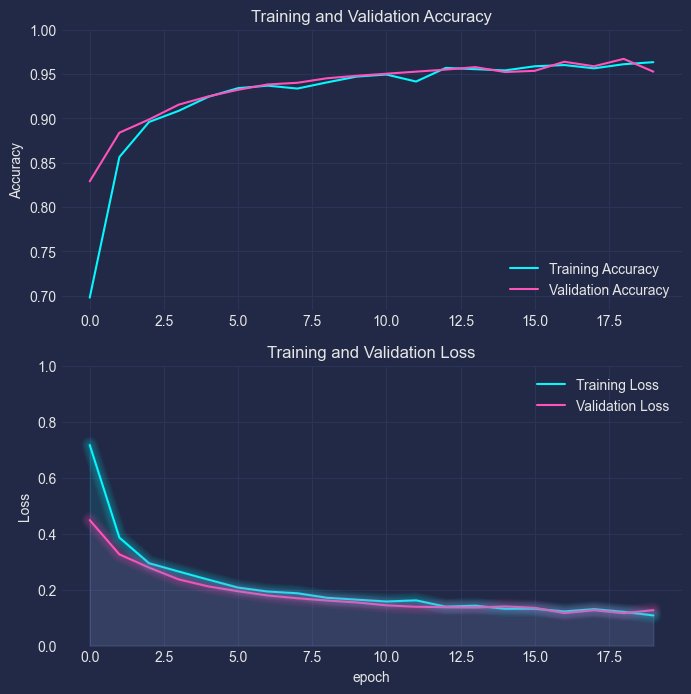

In [20]:
import mplcyberpunk
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.style.use("cyberpunk")
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
mplcyberpunk.add_glow_effects()
plt.show()

In [21]:
model.save('potato(vgg16).h5')